In [1]:
# -*- coding: utf-8 -*-
"""focal-aml.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Ha8_NyuGBH9yUn56bzm1oKkVQebLfchG
"""

# @title 1. Setup, Data Loading, and Feature Extraction
!pip install -q datasets transformers torch torchvision scikit-learn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import os # <-- ADDED: For file path checks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report # <-- FIXED: Added classification_report
from sklearn.manifold import TSNE # <-- FIXED: Added TSNE
import matplotlib.pyplot as plt


In [2]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Define Caching Files ---
FEATURE_FILE_A = 'X_A_features.pt'
FEATURE_FILE_B = 'X_B_features.pt'

# --- 1. Load Data OR Load Cached Features ---
if os.path.exists(FEATURE_FILE_A) and os.path.exists(FEATURE_FILE_B):
    print(f"--- Loading Cached Features from {FEATURE_FILE_A} and {FEATURE_FILE_B} ---")
    X_A = torch.load(FEATURE_FILE_A)
    X_B = torch.load(FEATURE_FILE_B)

    # Re-align device if necessary (features are saved to CPU)
    X_A = X_A.to(torch.float32)
    X_B = X_B.to(torch.float32)

else:
    print("--- Cached Features NOT FOUND. Starting Feature Extraction ---")
    print("--- 1. Load Data ---")
    ds = load_dataset("jxie/flickr8k", split='train')

    # CORRECTED: Iterate through all five caption columns and create one (image, caption) pair per row.
    data = []
    for item in ds:
        img = item['image']
        # Use 'caption_0', 'caption_1', etc. as confirmed by user metadata
        for i in range(5):
            caption_key = f'caption_{i}'
            caption_text = item[caption_key]
            if isinstance(caption_text, str) and caption_text.strip():
                data.append({'image': img, 'caption': caption_text.strip()})

    df = pd.DataFrame(data)

    # --- 1.1 Feature Extractor Setup ---
    # Image Encoder (A) - ResNet18 (512-dim features)
    image_processor = transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    image_model.fc = nn.Identity() # Output feature vector is 512 dimensions

    # Text Encoder (B) - BERT-base-uncased (768-dim features)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    text_model = AutoModel.from_pretrained("bert-base-uncased")

    image_model.to(device).eval()
    text_model.to(device).eval()

    # --- 1.2 Feature Extraction ---
    def extract_features(data_subset):
        image_features, text_features = [], []
        for index, item in data_subset.iterrows():
            # Image Feature (A)
            img_tensor = image_processor(item['image']).unsqueeze(0).to(device)
            with torch.no_grad():
                img_feat = image_model(img_tensor).squeeze().cpu().numpy()
            image_features.append(img_feat)

            # Text Feature (B)
            inputs = tokenizer(item['caption'], return_tensors="pt", padding='max_length', max_length=50, truncation=True)
            inputs.to(device)
            with torch.no_grad():
                # Use the [CLS] token output for sentence embedding
                text_feat = text_model(**inputs).last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            text_features.append(text_feat)

        X_A = torch.tensor(np.array(image_features), dtype=torch.float32)
        X_B = torch.tensor(np.array(text_features), dtype=torch.float32)
        return X_A, X_B

    X_A, X_B = extract_features(df)

    # --- Save Features for Next Run ---
    print(f"--- Saving extracted features to {FEATURE_FILE_A} and {FEATURE_FILE_B} ---")
    torch.save(X_A, FEATURE_FILE_A)
    torch.save(X_B, FEATURE_FILE_B)
    print("--- Features Saved ---")


--- Cached Features NOT FOUND. Starting Feature Extraction ---
--- 1. Load Data ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/687 [00:00<?, ?B/s]

data/train-00000-of-00002-2f8f6bfa852eac(…):   0%|          | 0.00/414M [00:00<?, ?B/s]

data/train-00001-of-00002-2173151d8cd6c7(…):   0%|          | 0.00/414M [00:00<?, ?B/s]

data/validation-00000-of-00001-7025a2b59(…):   0%|          | 0.00/138M [00:00<?, ?B/s]

data/test-00000-of-00001-42a2661d12c73e4(…):   0%|          | 0.00/137M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

--- Saving extracted features to X_A_features.pt and X_B_features.pt ---
--- Features Saved ---


In [ ]:

# --- 1.3 Simulated Downstream Target (Y) ---
# Creates a synthetic binary 'Conversion' label discoverable via features
# This must happen AFTER loading or extraction, as it depends on X_A and X_B
weights = np.random.rand(X_A.shape[1] + X_B.shape[1])
biases = np.random.randn(len(X_A)) * 0.5
combined_features = torch.cat((X_A, X_B), dim=1).numpy()
logits = combined_features @ weights + biases
# Set Y=1 for the top 50% of engagement scores
Y = torch.tensor((logits > np.median(logits)).astype(int), dtype=torch.long)

print(f"Data Loaded. Total Samples: {len(Y)} pairs.")
print(f"   Image (A) Dim: {X_A.shape[1]}, Text (B) Dim: {X_B.shape[1]}")


✅ Data Loaded. Total Samples: 30000 pairs.
   Image (A) Dim: 512, Text (B) Dim: 768


In [4]:

# --- 2. FOCAL Model Definition and Pre-training ---

# --- 2.1 FOCAL MLP Encoder Architecture ---
class FOCAL_Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.head_shared = nn.Linear(hidden_dim // 2, latent_dim)
        self.head_private = nn.Linear(hidden_dim // 2, latent_dim)

    def forward(self, x):
        h = self.encoder(x)
        shared = self.head_shared(h)
        private = self.head_private(h)
        return shared, private

# --- 2.2 FOCAL Main Model ---
class FOCAL(nn.Module):
    def __init__(self, dim_a, dim_b):
        super().__init__()
        self.enc_a = FOCAL_Encoder(dim_a)
        self.enc_b = FOCAL_Encoder(dim_b)

    def forward(self, xa, xb):
        sa, pa = self.enc_a(xa)
        sb, pb = self.enc_b(xb)
        return sa, pa, sb, pb


In [5]:

# --- 2.3 Training Setup ---
DIM_A = X_A.shape[1]
DIM_B = X_B.shape[1]
LATENT_DIM = 128
EPOCHS = 30
BATCH_SIZE = 128

model = FOCAL(DIM_A, DIM_B).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Split the data
X_A_train, X_A_test, X_B_train, X_B_test, Y_train, Y_test = train_test_split(
    X_A, X_B, Y, test_size=0.2, random_state=42
)
train_loader = DataLoader(TensorDataset(X_A_train, X_B_train), batch_size=BATCH_SIZE, shuffle=True)
print(f"\n--- 2. FOCAL Pre-training Started on {len(X_A_train)} samples ---")



--- 2. FOCAL Pre-training Started on 24000 samples ---


Epoch 10/30, Avg Loss: 0.0028
Epoch 20/30, Avg Loss: 0.0010
Epoch 30/30, Avg Loss: 0.0005


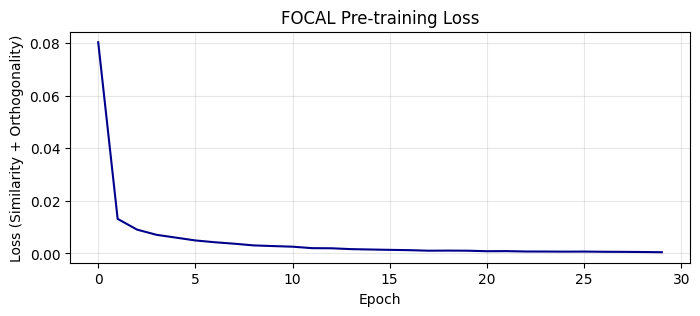

In [6]:

# --- 2.4 FOCAL Pre-training Loop ---
model.train()
loss_history = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for ba, bb in train_loader:
        ba, bb = ba.to(device), bb.to(device)
        optimizer.zero_grad()

        sa, pa, sb, pb = model(ba, bb)

        # Loss 1: Shared Similarity (Maximize semantic alignment)
        loss_sim = 1 - F.cosine_similarity(sa, sb).mean()

        # Loss 2: Orthogonality (Minimize correlation between Shared and Private)
        loss_ortho = torch.mean(torch.abs(torch.sum(sa*pa, 1))) + \
                     torch.mean(torch.abs(torch.sum(sb*pb, 1)))

        # Total Loss
        loss = loss_sim + 0.05 * loss_ortho
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss / len(train_loader))
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Avg Loss: {loss_history[-1]:.4f}")

# Visualize FOCAL Loss

plt.figure(figsize=(8, 3))
plt.plot(loss_history, color='darkblue')
plt.title("FOCAL Pre-training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Similarity + Orthogonality)")
plt.grid(True, alpha=0.3)
plt.show()


In [7]:

# --- 3. Downstream Task: Conversion Prediction ---
print("\n--- 3. Downstream Task: Conversion Prediction ---")

# --- 3.1 Extract Embeddings ---
model.eval()
with torch.no_grad():
    # Shared Embeddings
    sa_train, pa_train, sb_train, pb_train = model(X_A_train.to(device), X_B_train.to(device))
    Z_train_shared = torch.cat([sa_train, sb_train], dim=1).cpu().numpy()

    sa_test, pa_test, sb_test, pb_test = model(X_A_test.to(device), X_B_test.to(device))
    Z_test_shared = torch.cat([sa_test, sb_test], dim=1).cpu().numpy()

    # Full Embeddings (for baseline comparison)
    Z_train_full = torch.cat([sa_train, pa_train, sb_train, pb_train], dim=1).cpu().numpy()
    Z_test_full = torch.cat([sa_test, pa_test, sb_test, pb_test], dim=1).cpu().numpy()



--- 3. Downstream Task: Conversion Prediction ---


In [8]:

# --- 3.2 Train Prediction Head (Logistic Regression) ---

# Model 1: FOCAL Shared Space (S) - Expected to be robust
clf_shared = LogisticRegression(max_iter=500, solver='liblinear')
clf_shared.fit(Z_train_shared, Y_train.numpy())
preds_shared = clf_shared.predict(Z_test_shared)
acc_shared = accuracy_score(Y_test.numpy(), preds_shared)


In [ ]:

# Model 2: Full Embedding (S+P) - Baseline
clf_full = LogisticRegression(max_iter=500, solver='liblinear')
clf_full.fit(Z_train_full, Y_train.numpy())
preds_full = clf_full.predict(Z_test_full)
acc_full = accuracy_score(Y_test.numpy(), preds_full)

print(f" Accuracy (FOCAL Shared Embeddings): {acc_shared*100:.2f}%")
print(f" Accuracy (Full Embeddings S+P Baseline): {acc_full*100:.2f}%")
print("\nClassification Report (FOCAL Shared):")
print(classification_report(Y_test.numpy(), preds_shared))


🏆 Accuracy (FOCAL Shared Embeddings): 66.28%
📊 Accuracy (Full Embeddings S+P Baseline): 67.07%

Classification Report (FOCAL Shared):
              precision    recall  f1-score   support

           0       0.66      0.67      0.67      3014
           1       0.66      0.66      0.66      2986

    accuracy                           0.66      6000
   macro avg       0.66      0.66      0.66      6000
weighted avg       0.66      0.66      0.66      6000




--- Visualization: Shared Latent Space ---


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


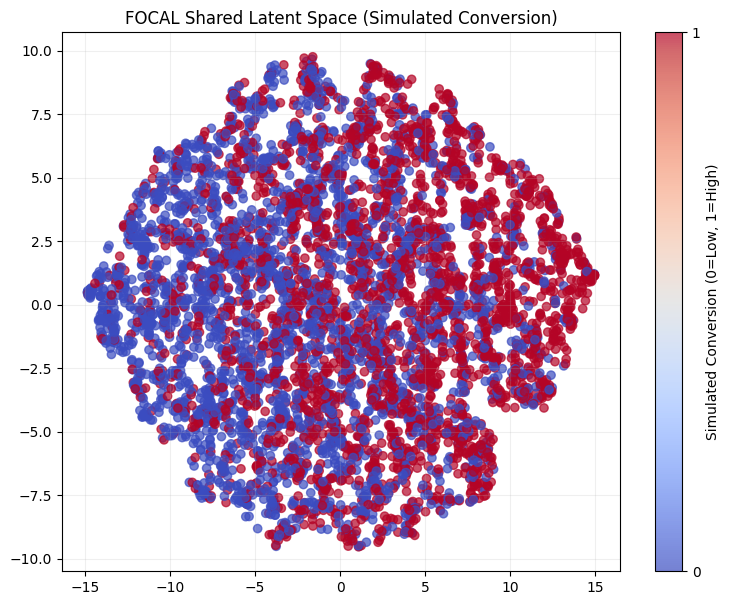

In [10]:

# --- 3.3 Visualization (t-SNE) ---
print("\n--- Visualization: Shared Latent Space ---")
# Apply t-SNE to the FOCAL Shared Test Embeddings
tsne = TSNE(n_components=2, random_state=42, n_iter=300)
z_viz = tsne.fit_transform(Z_test_shared)


plt.figure(figsize=(9, 7))
scatter = plt.scatter(z_viz[:,0], z_viz[:,1], c=Y_test.numpy(), cmap='coolwarm', alpha=0.7)
plt.title("FOCAL Shared Latent Space (Simulated Conversion)")
plt.colorbar(scatter, ticks=[0, 1], label='Simulated Conversion (0=Low, 1=High)')
plt.grid(True, alpha=0.2)
plt.show()


In [11]:

# --- 4. Model Saving ---
# A final step to save the trained FOCAL model for future use
MODEL_SAVE_PATH = 'focal_model.pt'
print(f"\n--- Saving FOCAL model to {MODEL_SAVE_PATH} ---")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Model saved successfully.")


--- Saving FOCAL model to focal_model.pt ---
Model saved successfully.



--- Additional Visualization: Private Latent Space ---


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


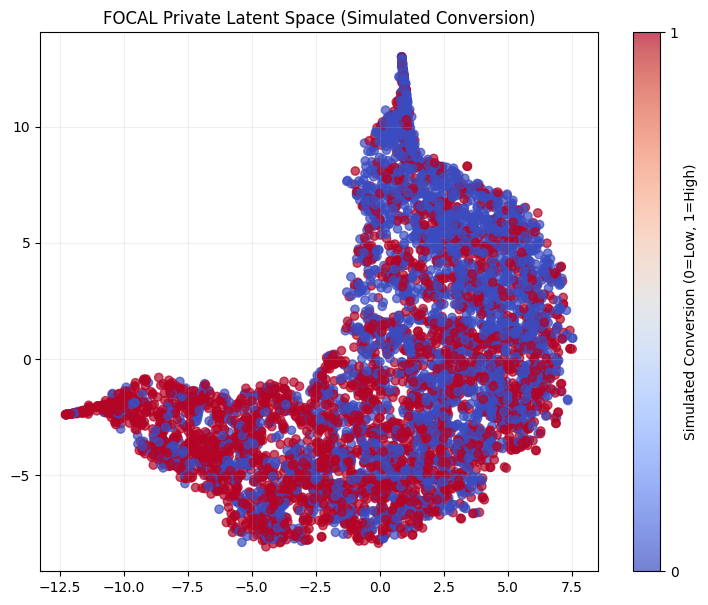

In [12]:
# Assuming the trained 'model', test data (X_A_test, X_B_test),
# and labels (Y_test) are available from the main script execution.

print("\n--- Additional Visualization: Private Latent Space ---")

# 1. Extract Private Embeddings for the test set
# (Ensures pa_test and pb_test are defined in the current scope)
model.eval()
with torch.no_grad():
    # Pa_test and Pb_test are the private embeddings from the two encoders
    sa_test, pa_test, sb_test, pb_test = model(X_A_test.to(device), X_B_test.to(device))

    # 2. Concatenate the private embeddings (Pa + Pb)
    # Move tensor to CPU and convert to NumPy array for t-SNE
    Z_test_private = torch.cat([pa_test, pb_test], dim=1).cpu().numpy()

# 3. Apply t-SNE to the FOCAL Private Test Embeddings
tsne_private = TSNE(n_components=2, random_state=42, n_iter=300, learning_rate='auto', init='random')
z_viz_private = tsne_private.fit_transform(Z_test_private)

# 4. Plot the results
plt.figure(figsize=(9, 7))
scatter = plt.scatter(z_viz_private[:,0], z_viz_private[:,1], c=Y_test.numpy(), cmap='coolwarm', alpha=0.7)
plt.title("FOCAL Private Latent Space (Simulated Conversion)")
plt.colorbar(scatter, ticks=[0, 1], label='Simulated Conversion (0=Low, 1=High)')
plt.grid(True, alpha=0.2)
plt.show()

--- Visualization 1: Private Space Separation (Color by Modality) ---


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


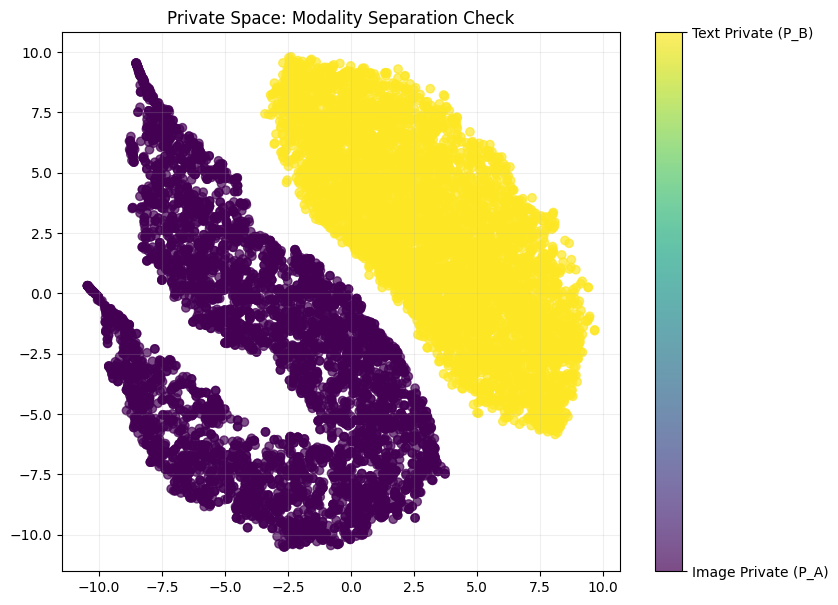

In [13]:
# Code Block 1: Private Space Separation (Color by Modality)
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print("--- Visualization 1: Private Space Separation (Color by Modality) ---")

# Ensure embeddings are extracted (reuse variables from main script for efficiency)
# If not already extracted: sa_test, pa_test, sb_test, pb_test = model(X_A_test.to(device), X_B_test.to(device))

# Stack P_A and P_B for t-SNE: P_A samples first, then P_B samples
P_A_np = pa_test.cpu().numpy()
P_B_np = pb_test.cpu().numpy()
Z_test_stacked_private = np.vstack([P_A_np, P_B_np])

# Create modality labels: 0 for P_A (Image), 1 for P_B (Text)
labels_modality = np.concatenate([
    np.zeros(P_A_np.shape[0]),
    np.ones(P_B_np.shape[0])
])

# Apply t-SNE
tsne_private_sep = TSNE(n_components=2, random_state=42, n_iter=300, learning_rate='auto', init='random')
z_viz_private_stacked = tsne_private_sep.fit_transform(Z_test_stacked_private)

# Plot
plt.figure(figsize=(9, 7))
scatter = plt.scatter(z_viz_private_stacked[:,0], z_viz_private_stacked[:,1],
                      c=labels_modality, cmap='viridis', alpha=0.7)
plt.title("Private Space: Modality Separation Check")
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.set_ticklabels(['Image Private (P_A)', 'Text Private (P_B)'])
plt.grid(True, alpha=0.2)
plt.show()


--- Visualization 2: Shared Space Alignment (Color by Task Y) ---


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


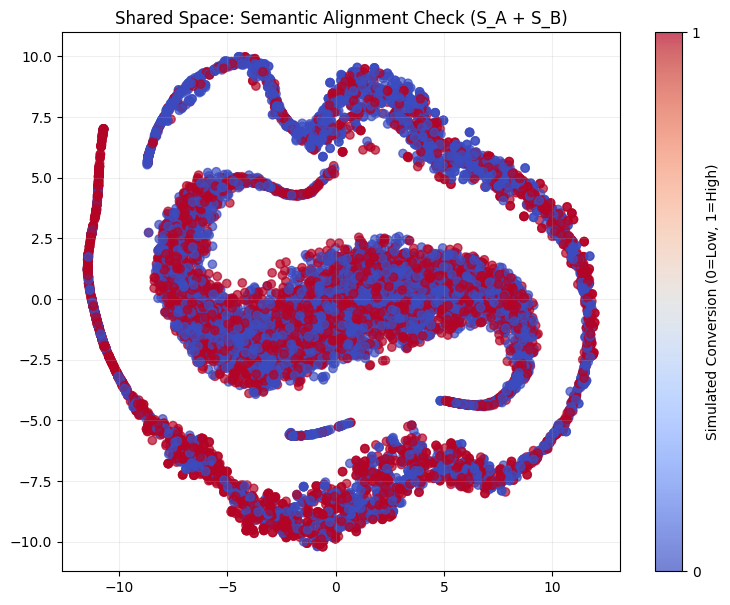

In [14]:
# Code Block 2: Shared Space Alignment (Color by Shared Task Label Y)
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print("\n--- Visualization 2: Shared Space Alignment (Color by Task Y) ---")

# Reuse extracted embeddings (sa_test, sb_test) from the main script or previous block

# Stack S_A and S_B for t-SNE: S_A samples first, then S_B samples
S_A_np = sa_test.cpu().numpy()
S_B_np = sb_test.cpu().numpy()
Z_test_stacked_shared = np.vstack([S_A_np, S_B_np])

# Create task labels: Y_test is repeated for both S_A and S_B samples
labels_task = np.concatenate([
    Y_test.cpu().numpy(),
    Y_test.cpu().numpy()
])

# Apply t-SNE
tsne_shared_align = TSNE(n_components=2, random_state=42, n_iter=300, learning_rate='auto', init='random')
z_viz_shared_stacked = tsne_shared_align.fit_transform(Z_test_stacked_shared)

# Plot
plt.figure(figsize=(9, 7))
scatter = plt.scatter(z_viz_shared_stacked[:,0], z_viz_shared_stacked[:,1],
                      c=labels_task, cmap='coolwarm', alpha=0.7)
plt.title("Shared Space: Semantic Alignment Check (S_A + S_B)")
plt.colorbar(scatter, ticks=[0, 1], label='Simulated Conversion (0=Low, 1=High)')
plt.grid(True, alpha=0.2)
plt.show()